## Dependencias

In [102]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,r2_score

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from varclushi import VarClusHi

from functools import reduce
from dateutil.relativedelta import relativedelta as rd

import warnings
import os 

warnings.filterwarnings('ignore')
cf.go_offline()

## Lectura de datos

In [2]:
ruta = '/media/jose/090f6b94-de30-4aaf-9f8a-4e18b120d7f6/bd/stocks/full_history'

In [5]:
muestra = np.random.choice(os.listdir(ruta), 20,replace=False)
len(muestra),muestra

(20,
 array(['FTRI.csv', 'PTMN.csv', 'QTWO.csv', 'RBBN.csv', 'SMBC.csv',
        'CEPU.csv', 'IGT.csv', 'SOR.csv', 'SMMC.csv', 'VTIQ.csv',
        'EWA.csv', 'SMP.csv', 'KZR.csv', 'FCA.csv', 'RLY.csv', 'MORF.csv',
        'PSC.csv', 'TBNK.csv', 'CHE.csv', 'UOCT.csv'], dtype='<U11'))

In [14]:
def leerArchivo(arch):
    df = pd.read_csv(os.path.join(ruta,arch),usecols=['date','open','close','high','low'])
    nombre = arch.split('.')[0]
    df['date'] = pd.to_datetime(df['date']).dt.date
    df.insert(1,'accion',nombre)
    return df

In [26]:
df = pd.concat(map(leerArchivo,muestra),ignore_index=True)

In [27]:
df.shape

(72669, 6)

## Ingeniería de características

In [28]:
vobs = 15
vdes = 1
step = 3 

### Inspección inicial

In [29]:
df['date'].map(lambda x: x.strftime('%Y-%m')).value_counts().sort_index().iplot(
    kind='bar', title='Observaciones por mes', color='purple')


In [30]:
fhf,fhi = df['date'].max(),df['date'].max()+rd(years=-1)
fhi,fhf

(datetime.date(2019, 7, 2), datetime.date(2020, 7, 2))

In [31]:
df = df[(df['date']>=fhi)&(df['date']<=fhf)].reset_index(drop=True)
df.shape

(4549, 6)

In [32]:
df['date'].map(lambda x: x.strftime('%Y-%m')).value_counts().sort_index().iplot(
    kind='bar', title='Observaciones por mes', color='purple')


### Catálogo de fechas

In [39]:
catfh = df[['date']].drop_duplicates().sort_values('date').reset_index(drop=True)
catfh.insert(0,'id',catfh.index+1)
df = df.merge(catfh,on='date',how='inner').drop('date',axis=1)
df.head()

,accion,open,high,low,close,id
0,FTRI,9.680000,9.720000,9.680000,9.69,254
1,PTMN,1.100000,1.120000,1.090000,1.09,254
2,QTWO,88.739998,89.000000,86.629997,87.82,254
3,RBBN,3.900000,4.080000,3.870000,3.98,254
4,SMBC,24.110001,24.110001,23.129999,23.23,254


In [40]:
anclai,anclaf = df['id'].min()+vobs-1,df['id'].max()-vdes
anclai,anclaf

(15, 253)

### Matriz de predictoras $\mathcal{X}$

In [51]:
varc = ['open','close','high','low']

In [79]:
um  = ['accion','ancla']

In [80]:
cruzar = lambda x,y: x.merge(y,on=um,how='outer')
apilar = lambda x,y: pd.concat([x,y],ignore_index=True)

In [87]:
def ingX(df,ancla,sub)->pd.DataFrame:
    aux = df[(df['id']<=ancla)&(df['id']>=(ancla-sub+1))].copy().reset_index(drop=True)
    funciones = [np.mean,np.median,np.std,np.min,np.max]
    nombresf = ['mean','median','std','min','max']
    l = []
    for v in varc:
        for nombre,func in zip(nombresf,funciones):
            nombre = f'x_{nombre}_{v}_{sub}'
            agg = aux[['accion',v]].groupby('accion').agg(func).rename(columns={v:nombre}).reset_index()
            agg.insert(1,'ancla',ancla)
            l.append(agg)
    aux = reduce(cruzar,l)
    return aux

In [89]:
X =reduce(cruzar,map(lambda sub: reduce(apilar, map(lambda ancla: ingX(df, ancla, sub),
    range(anclai, anclaf+1))), range(step, vobs+step, step)))


In [91]:
X.head()

,accion,ancla,x_mean_open_3,x_median_open_3,x_std_open_3,x_min_open_3,x_max_open_3,x_mean_close_3,x_median_close_3,x_std_close_3,...,x_mean_high_15,x_median_high_15,x_std_high_15,x_min_high_15,x_max_high_15,x_mean_low_15,x_median_low_15,x_std_low_15,x_min_low_15,x_max_low_15
0,CEPU,15,9.163333,9.160000,0.155027,9.010000,9.320000,9.076667,9.030000,0.089629,...,9.473333,9.400000,0.288114,9.050000,9.990000,9.182667,9.110000,0.267174,8.910000,9.800000
1,CHE,15,372.866669,372.130005,3.267880,370.029999,376.440002,370.576660,370.839996,0.942986,...,374.750667,373.589996,5.158992,365.790009,384.640015,369.354669,369.049988,4.935493,359.589996,379.540009
2,EWA,15,22.786667,22.780001,0.030550,22.760000,22.820000,22.753333,22.750000,0.045093,...,22.678667,22.670000,0.122467,22.450001,22.850000,22.566667,22.549999,0.107415,22.379999,22.730000
3,FCA,15,26.063334,26.000000,0.231588,25.870001,26.320000,26.060000,26.000000,0.235796,...,26.177333,26.139999,0.368771,25.750000,27.049999,26.148000,26.139999,0.357815,25.750000,27.049999
4,FTRI,15,12.186666,12.160000,0.055076,12.150000,12.250000,12.190000,12.170000,0.034641,...,12.188571,12.180000,0.087518,12.040000,12.380000,12.166428,12.170000,0.081487,12.000000,12.270000


### Vector respuesta $\vec{y}$

In [102]:
def ingY(df,ancla)->pd.DataFrame:
    aux = df[(df['id']>ancla)&(df['id']<=(ancla+vdes))].copy().reset_index(drop=True)[['accion','close']]
    aux = aux.rename(columns={'close':'y'})
    aux.insert(1,'ancla',ancla)
    return aux

In [104]:
y = reduce(apilar,map(lambda ancla : ingY(df,ancla),range(anclai,anclaf+1)))

In [106]:
tad = X.merge(y,on=um,how='inner')

In [108]:
tad.head()

,accion,ancla,x_mean_open_3,x_median_open_3,x_std_open_3,x_min_open_3,x_max_open_3,x_mean_close_3,x_median_close_3,x_std_close_3,...,x_median_high_15,x_std_high_15,x_min_high_15,x_max_high_15,x_mean_low_15,x_median_low_15,x_std_low_15,x_min_low_15,x_max_low_15,y
0,CEPU,15,9.163333,9.160000,0.155027,9.010000,9.320000,9.076667,9.030000,0.089629,...,9.400000,0.288114,9.050000,9.990000,9.182667,9.110000,0.267174,8.910000,9.800000,8.980000
1,CHE,15,372.866669,372.130005,3.267880,370.029999,376.440002,370.576660,370.839996,0.942986,...,373.589996,5.158992,365.790009,384.640015,369.354669,369.049988,4.935493,359.589996,379.540009,372.170013
2,EWA,15,22.786667,22.780001,0.030550,22.760000,22.820000,22.753333,22.750000,0.045093,...,22.670000,0.122467,22.450001,22.850000,22.566667,22.549999,0.107415,22.379999,22.730000,22.809999
3,FCA,15,26.063334,26.000000,0.231588,25.870001,26.320000,26.060000,26.000000,0.235796,...,26.139999,0.368771,25.750000,27.049999,26.148000,26.139999,0.357815,25.750000,27.049999,25.910000
4,IGT,15,13.116667,13.060000,0.181750,12.970000,13.320000,13.050000,13.030000,0.141067,...,13.520000,0.227219,13.120000,13.920000,13.188667,13.250000,0.252413,12.730000,13.590000,13.410000


In [109]:
tad.to_parquet('../data/tad_acciones_regresion.parquet')

In [3]:
tad = pd.read_parquet('../data/tad_acciones_regresion.parquet')
tad.shape

(4281, 103)

In [4]:
tad.head()

,accion,ancla,x_mean_open_3,x_median_open_3,x_std_open_3,x_min_open_3,x_max_open_3,x_mean_close_3,x_median_close_3,x_std_close_3,...,x_median_high_15,x_std_high_15,x_min_high_15,x_max_high_15,x_mean_low_15,x_median_low_15,x_std_low_15,x_min_low_15,x_max_low_15,y
0,CEPU,15,9.163333,9.160000,0.155027,9.010000,9.320000,9.076667,9.030000,0.089629,...,9.400000,0.288114,9.050000,9.990000,9.182667,9.110000,0.267174,8.910000,9.800000,8.980000
1,CHE,15,372.866669,372.130005,3.267880,370.029999,376.440002,370.576660,370.839996,0.942986,...,373.589996,5.158992,365.790009,384.640015,369.354669,369.049988,4.935493,359.589996,379.540009,372.170013
2,EWA,15,22.786667,22.780001,0.030550,22.760000,22.820000,22.753333,22.750000,0.045093,...,22.670000,0.122467,22.450001,22.850000,22.566667,22.549999,0.107415,22.379999,22.730000,22.809999
3,FCA,15,26.063334,26.000000,0.231588,25.870001,26.320000,26.060000,26.000000,0.235796,...,26.139999,0.368771,25.750000,27.049999,26.148000,26.139999,0.357815,25.750000,27.049999,25.910000
4,IGT,15,13.116667,13.060000,0.181750,12.970000,13.320000,13.050000,13.030000,0.141067,...,13.520000,0.227219,13.120000,13.920000,13.188667,13.250000,0.252413,12.730000,13.590000,13.410000


### Partición

In [5]:
Sn, ot = [d.reset_index(drop=True) for _,d in tad.groupby(tad['ancla']>=217)]
Sn.shape,ot.shape

((3664, 103), (617, 103))

In [7]:
train,valid = train_test_split(Sn,test_size=0.3,random_state=123)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((2564, 103), (1100, 103))

## Análisis exploratorio de datos

In [23]:
um = ['accion','ancla']

In [10]:
varc = [v for v in train.columns if v.startswith('x_')]
len(varc)

100

### Ausentes

In [17]:
miss = (train[varc].isnull().sum()/len(train)).to_frame().rename(columns={0:'pct_miss'})
miss.sort_values(by='pct_miss',ascending=False,inplace=True)
miss

,pct_miss
x_std_open_3,0.017551
x_std_close_3,0.017551
x_std_low_3,0.017551
x_std_high_3,0.017551
x_std_close_6,0.002340
...,...
x_max_open_15,0.000000
x_min_open_15,0.000000
x_median_open_15,0.000000
x_mean_open_15,0.000000


In [21]:
im = SimpleImputer(strategy='median')
im.fit(train[varc])

SimpleImputer(strategy='median')

In [45]:
Xi = pd.DataFrame(im.transform(train[varc]),columns=varc)
Xi[um] = train[um]

In [46]:
ks = pd.DataFrame(map(lambda v: (v, stats.ks_2samp(Xi[v], train[v].dropna(
)).statistic), varc), columns=['var', 'ks']).sort_values(by='ks', ascending=False)
ks


,var,ks
2,x_std_open_3,0.008772
7,x_std_close_3,0.008772
17,x_std_low_3,0.008772
12,x_std_high_3,0.008772
32,x_std_high_6,0.001170
...,...,...
85,x_mean_close_15,0.000000
84,x_max_open_15,0.000000
81,x_median_open_15,0.000000
80,x_mean_open_15,0.000000


### Multicolinealidad

In [47]:
vc = VarClusHi(df=Xi,feat_list=varc).varclus()

In [48]:
best = sorted(vc.rsquare.sort_values(by=['Cluster','RS_Ratio'],ascending=[1,1]).groupby('Cluster').first()['Variable'])
best

['x_mean_close_9', 'x_std_close_9']

### Extremos

array([[<Axes: title={'center': 'x_mean_close_9'}>,
        <Axes: title={'center': 'x_std_close_9'}>]], dtype=object)

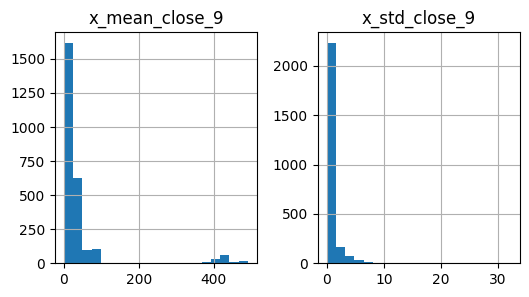

In [60]:
Xi[best].hist(figsize=(6,3),bins=20)

In [57]:
for v,li,ls in Xi[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    Xi[f'ex_{v}'] = Xi[v].apply(lambda x: 1 if x<li or x>ls else 0)
Xi['ex_'] = Xi[[v for v in Xi.columns if v.startswith('ex_')]].max(axis=1)
Xi['ex_'].value_counts(1)


0    0.961778
1    0.038222
Name: ex_, dtype: float64

array([[<Axes: title={'center': 'x_mean_close_9'}>,
        <Axes: title={'center': 'x_std_close_9'}>]], dtype=object)

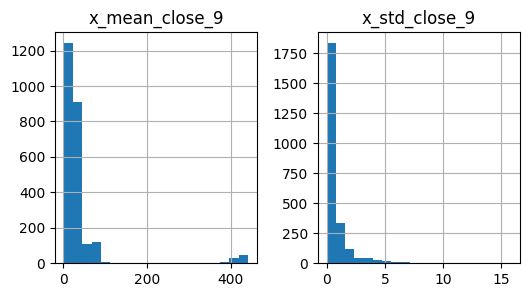

In [61]:
Xi[Xi['ex_']==0][best].hist(figsize=(6,3),bins=20)

In [62]:
Xi = Xi[Xi['ex_']==0].reset_index(drop=True)
Xi.drop([v for v in Xi.columns if v.startswith('ex_')],axis=1,inplace=True)

In [65]:
im.fit(train[best])

SimpleImputer(strategy='median')

In [68]:
vart = ['y']

In [75]:
aux = Xi[um+best].merge(train[um+vart],on=um,how='inner')
Xt,yt = aux[um+best].copy(),aux[um+vart].copy()


## Aprendizaje

In [81]:
reg = Ridge()

In [82]:
reg.fit(Xt[best],yt[vart[0]])

Ridge()

In [84]:
reg.coef_,reg.intercept_

(array([1.00213394, 0.36221693]), -0.3703183658869946)

## Generalización

In [104]:
pipe = make_pipeline(im,reg)
print({'train':mean_absolute_percentage_error(y_pred=pipe.predict(Xt[best]),y_true=yt[vart[0]])})
print({'valid':mean_absolute_percentage_error(y_pred=pipe.predict(valid[best]),y_true=valid[vart[0]])})
print({'test':mean_absolute_percentage_error(y_pred=pipe.predict(ot[best]),y_true=ot[vart[0]])})

{'train': 0.054473856394922}
{'valid': 0.05560825668376709}
{'test': 0.06611107266807348}


In [105]:
print({'train':mean_absolute_error(y_pred=pipe.predict(Xt[best]),y_true=yt[vart[0]])})
print({'valid':mean_absolute_error(y_pred=pipe.predict(valid[best]),y_true=valid[vart[0]])})
print({'test':mean_absolute_error(y_pred=pipe.predict(ot[best]),y_true=ot[vart[0]])})

{'train': 1.0870226768335223}
{'valid': 1.6086049024829143}
{'test': 1.6873696468454897}


In [106]:
print({'train':mean_squared_error(y_pred=pipe.predict(Xt[best]),y_true=yt[vart[0]])})
print({'valid':mean_squared_error(y_pred=pipe.predict(valid[best]),y_true=valid[vart[0]])})
print({'test':mean_squared_error(y_pred=pipe.predict(ot[best]),y_true=ot[vart[0]])})

{'train': 5.446550837920861}
{'valid': 24.022921226392665}
{'test': 18.46393540423286}


In [107]:
print({'train':mean_squared_error(y_pred=pipe.predict(Xt[best]),y_true=yt[vart[0]])})
print({'valid':mean_squared_error(y_pred=pipe.predict(valid[best]),y_true=valid[vart[0]])})
print({'test':mean_squared_error(y_pred=pipe.predict(ot[best]),y_true=ot[vart[0]])})

{'train': 5.446550837920861}
{'valid': 24.022921226392665}
{'test': 18.46393540423286}


In [108]:
print({'train':r2_score(y_pred=pipe.predict(Xt[best]),y_true=yt[vart[0]])})
print({'valid':r2_score(y_pred=pipe.predict(valid[best]),y_true=valid[vart[0]])})
print({'test':r2_score(y_pred=pipe.predict(ot[best]),y_true=ot[vart[0]])})

{'train': 0.9989581308669138}
{'valid': 0.9978593886387847}
{'test': 0.998308941446772}


In [109]:
valid['y^'] = pipe.predict(valid[best])
ot['y^'] = pipe.predict(ot[best])

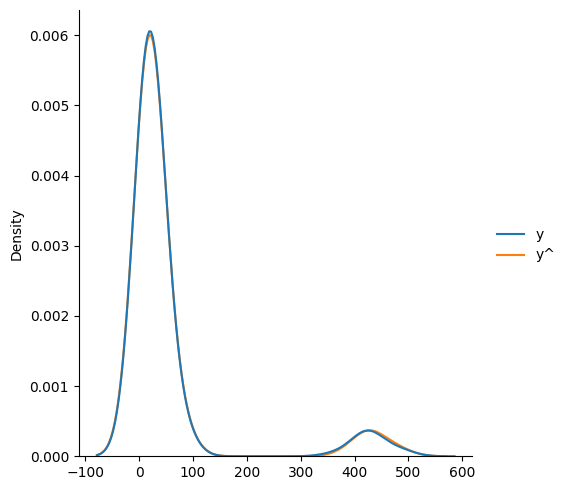

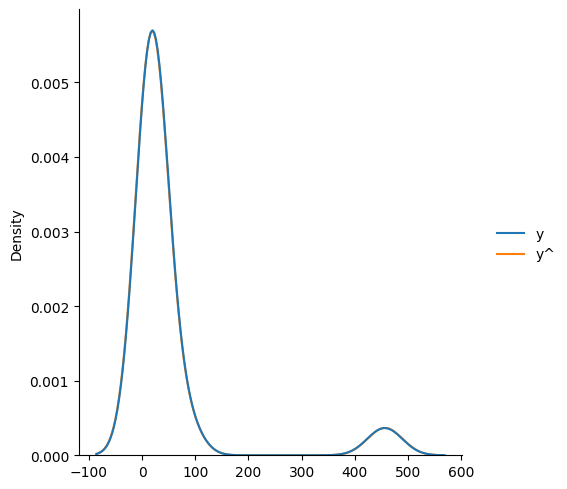

In [110]:
sns.displot(valid[vart+['y^']],kind='kde')
sns.displot(ot[vart+['y^']],kind='kde')


In [111]:
ot.sample(5)[['y^']+vart]

,y^,y
380,22.562240,22.080000
222,81.915850,82.620003
276,82.817926,85.050003
197,17.288439,18.490000
429,19.723060,19.379999


In [98]:
best

['x_mean_close_9', 'x_std_close_9']